### Imports and Load Dataset 
Starting point - we take the existing preprocessed dataset OMdb_merged.csv

In [104]:
import pandas as pd
import numpy as np
import cpi
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

In [2]:
pd.set_option('max_columns', None)

In [3]:
OMdb = pd.read_csv('data/OMdb_merged.csv')

In [4]:
OMdb.head(2)

,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,IMdb_ID,IMdb_score,Language,Metascore,Plot,Production,RT_score,Rated,Released,Runtime,TMdb_id,Title,Type,Website,Year,actor_1,actor_2,awards,bo_year,bo_year_rank,director_1,director_2,domestic-gross,domestic-pct,imdbVotes,itunes_id,logBoxOffice,mojo_title,nominations,num_actor,num_director,num_genre,num_lang,oscar_noms,oscar_wins,overseas-gross,overseas-pct,search_strs,studio,titles,worldwide-gross,years,Writer 1,Writer 2,Writer 3,Writer 4,budget,Cast 1,Cast 2,Cast 3,Cast 4,Cast 5,Cast 6
0,"Neel Sethi, Bill Murray, Ben Kingsley, Idris Elba",Won 1 Oscar. Another 31 wins & 54 nominations.,363995937.0,"UK, USA",30 Aug 2016,Jon Favreau,"Adventure, Drama, Family, Fantasy",tt3040964,74.0,English,77.0,After a threat from the tiger Shere Khan force...,Walt Disney Pictures,95.0,PG,15 Apr 2016,106.0,"[278927, 183407, 534412, 399014]",The Jungle Book,movie,http://movies.disney.com/the-jungle-book-2016,2016,Neel Sethi,Bill Murray,31.0,2016.0,5.0,Jon Favreau,0,364000000.0,37.7,231929.0,1098066757,8.561097,The Jungle Book 2016,54.0,4,1,4,1.0,0.0,1.0,602500000.0,62.3,The+Jungle+Book+2016,BV,The Jungle Book (2016),966600000.0,2016,Justin Marks,Writer Not Available,Writer Not Available,Writer Not Available,175000000.0,Neel Sethi,Neel Sethi,Bill Murray,Ben Kingsley,Idris Elba,Lupita Nyong'o
1,"Neel Sethi, Bill Murray, Ben Kingsley, Idris Elba",Won 1 Oscar. Another 31 wins & 54 nominations.,363995937.0,"UK, USA",30 Aug 2016,Jon Favreau,"Adventure, Drama, Family, Fantasy",tt3040964,74.0,English,77.0,After a threat from the tiger Shere Khan force...,Walt Disney Pictures,95.0,PG,15 Apr 2016,106.0,"[278927, 183407, 534412, 399014]",The Jungle Book,movie,http://movies.disney.com/the-jungle-book-2016,2016,Neel Sethi,Bill Murray,31.0,2016.0,5.0,Jon Favreau,0,364000000.0,37.7,231929.0,1098066757,8.561097,The Jungle Book 2016,54.0,4,1,4,1.0,0.0,1.0,602500000.0,62.3,The+Jungle+Book+2016,BV,The Jungle Book (2016),966600000.0,2016,Justin Marks,Writer Not Available,Writer Not Available,Writer Not Available,175000000.0,Bruce Reitherman,Louis Prima,Sterling Holloway,J. Pat O'Malley,Darleen Carr,Phil Harris


1. We need to adjust the worldwide-gross and budget column values for inflation. Here is a how-to:
https://medium.com/analytics-vidhya/adjusting-for-inflation-when-analysing-historical-dat a-with-python-9d69a8dcbc27
Let’s just adjust all of the movie dollars in the “budget” and “worldwide-gross” columns to today’s present value in dollars (so 2020, 2019 doesn’t matter just something recent). Please replace those column values with the adjusted value in dollars. So we keep the original columns.

In [5]:
cpi.update()

In [6]:
def inflate_column(data, column): 
    return data.apply(lambda x:cpi.inflate(x[column], x.Year), axis = 1)

In [7]:
OMdb['real_budget'] = inflate_column(OMdb, 'budget')
OMdb['real_revenue'] = inflate_column(OMdb, 'worldwide-gross')

ref: https://medium.com/analytics-vidhya/adjusting-for-inflation-when-analysing-historical-data-with-python-9d69a8dcbc27

2. Since movie runtime is in units of minutes (100 minutes) and revenue/budget is in millions of dollars ($100M), we will need to normalize the data in the dataset. Please normalize all data columns in the dataset.

In [8]:
scaler = MinMaxScaler()
OMdb_scaled = scaler.fit_transform(OMdb._get_numeric_data())

In [9]:
norm = pd.DataFrame(OMdb_scaled, columns = OMdb._get_numeric_data().columns)

In [10]:
norm.head(2)

,BoxOffice,IMdb_score,Metascore,RT_score,Runtime,Year,awards,bo_year,bo_year_rank,domestic-gross,domestic-pct,imdbVotes,itunes_id,logBoxOffice,nominations,num_actor,num_director,num_genre,num_lang,oscar_noms,oscar_wins,overseas-gross,overseas-pct,worldwide-gross,years,budget,real_budget,real_revenue
0,0.485522,0.757576,0.736256,0.935347,0.469274,0.964286,0.133621,1.0,0.02381,0.485452,0.366226,0.116529,0.725974,0.964643,0.246575,1.0,0.0,0.5,0.0,0.0,0.090909,0.297164,0.633774,0.348045,0.964286,0.58166,0.500992,0.303625
1,0.485522,0.757576,0.736256,0.935347,0.469274,0.964286,0.133621,1.0,0.02381,0.485452,0.366226,0.116529,0.725974,0.964643,0.246575,1.0,0.0,0.5,0.0,0.0,0.090909,0.297164,0.633774,0.348045,0.964286,0.58166,0.500992,0.303625


In [11]:
def replace_norms(OMdb_df, norm_df):
    cols = norm_df.columns
    for col in cols: 
        OMdb_df[col] = norm_df[col]

In [12]:
replace_norms(OMdb, norm)

In [13]:
OMdb.head(2)

,Actors,Awards,BoxOffice,Country,DVD,Director,Genre,IMdb_ID,IMdb_score,Language,Metascore,Plot,Production,RT_score,Rated,Released,Runtime,TMdb_id,Title,Type,Website,Year,actor_1,actor_2,awards,bo_year,bo_year_rank,director_1,director_2,domestic-gross,domestic-pct,imdbVotes,itunes_id,logBoxOffice,mojo_title,nominations,num_actor,num_director,num_genre,num_lang,oscar_noms,oscar_wins,overseas-gross,overseas-pct,search_strs,studio,titles,worldwide-gross,years,Writer 1,Writer 2,Writer 3,Writer 4,budget,Cast 1,Cast 2,Cast 3,Cast 4,Cast 5,Cast 6,real_budget,real_revenue
0,"Neel Sethi, Bill Murray, Ben Kingsley, Idris Elba",Won 1 Oscar. Another 31 wins & 54 nominations.,0.485522,"UK, USA",30 Aug 2016,Jon Favreau,"Adventure, Drama, Family, Fantasy",tt3040964,0.757576,English,0.736256,After a threat from the tiger Shere Khan force...,Walt Disney Pictures,0.935347,PG,15 Apr 2016,0.469274,"[278927, 183407, 534412, 399014]",The Jungle Book,movie,http://movies.disney.com/the-jungle-book-2016,0.964286,Neel Sethi,Bill Murray,0.133621,1.0,0.02381,Jon Favreau,0,0.485452,0.366226,0.116529,0.725974,0.964643,The Jungle Book 2016,0.246575,1.0,0.0,0.5,0.0,0.0,0.090909,0.297164,0.633774,The+Jungle+Book+2016,BV,The Jungle Book (2016),0.348045,0.964286,Justin Marks,Writer Not Available,Writer Not Available,Writer Not Available,0.58166,Neel Sethi,Neel Sethi,Bill Murray,Ben Kingsley,Idris Elba,Lupita Nyong'o,0.500992,0.303625
1,"Neel Sethi, Bill Murray, Ben Kingsley, Idris Elba",Won 1 Oscar. Another 31 wins & 54 nominations.,0.485522,"UK, USA",30 Aug 2016,Jon Favreau,"Adventure, Drama, Family, Fantasy",tt3040964,0.757576,English,0.736256,After a threat from the tiger Shere Khan force...,Walt Disney Pictures,0.935347,PG,15 Apr 2016,0.469274,"[278927, 183407, 534412, 399014]",The Jungle Book,movie,http://movies.disney.com/the-jungle-book-2016,0.964286,Neel Sethi,Bill Murray,0.133621,1.0,0.02381,Jon Favreau,0,0.485452,0.366226,0.116529,0.725974,0.964643,The Jungle Book 2016,0.246575,1.0,0.0,0.5,0.0,0.0,0.090909,0.297164,0.633774,The+Jungle+Book+2016,BV,The Jungle Book (2016),0.348045,0.964286,Justin Marks,Writer Not Available,Writer Not Available,Writer Not Available,0.58166,Bruce Reitherman,Louis Prima,Sterling Holloway,J. Pat O'Malley,Darleen Carr,Phil Harris,0.500992,0.303625


3. We need to run onehotencoding again on the normalized and adjusted dataset >> Please output copy of the dataset (.csv) with only the onehotencoding

In [14]:
cat_cols = np.array(pd.DataFrame(OMdb.dtypes[OMdb.dtypes == 'object']).index)

In [15]:
ohe = OneHotEncoder(drop = 'first')
ohe_array = ohe.fit_transform(OMdb[cat_cols]).toarray()
ohe_OMdb = pd.DataFrame(ohe_array, index = OMdb.index, columns = ohe.get_feature_names())

In [16]:
ohe_OMdb.to_csv('data/ohe_cols.csv', index = False)

In [17]:
OMdb_drop_col = OMdb.drop(columns = cat_cols)

In [18]:
OMdb_ohed = pd.concat([OMdb_drop_col, ohe_OMdb], axis = 1)

4. We need to rerun all the graphs again with this updated dataset >> Please also output copy of the image files for these graphs

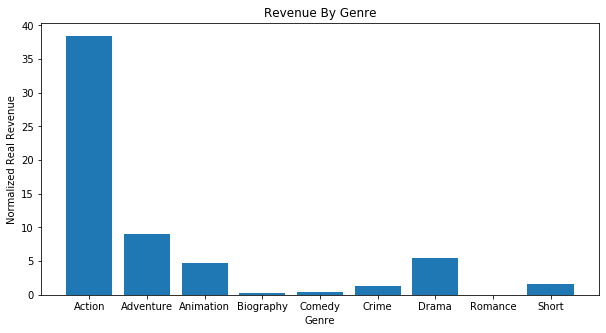

In [19]:
'''
1. Graph #1 to Plot revenue by genre. Revenue comes from “worldwide-gross” and “Genre” in OMDb_mojo_clean.csv. 
Now some of the genre categories are multiples, 
you can count each combination as a unique category OR just pick one category in the list as the genre. 
So if a data point has Genre = Action, Comedy, Animation, we can pick “Action” or “Comedy” 
or “Animation” as its genre
'''

OMdb['genre_1'] = [i.split(',')[0] for i in OMdb['Genre'] ]
genre_revenue_df= pd.DataFrame(OMdb.groupby(['genre_1']).sum()['real_revenue'])
plt.figure(figsize = (10, 5))
plt.bar(genre_revenue_df.index, genre_revenue_df['real_revenue'])
plt.title('Revenue By Genre')
plt.xlabel('Genre')
plt.ylabel('Normalized Real Revenue')
plt.savefig('images/real_revenue_by_genre.png');

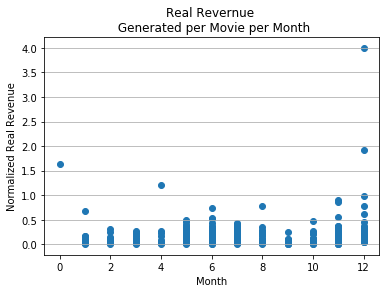

In [20]:
'''
2. Take all the movies and bin them by the month that they are released. 
The year of release we do not care about. Then plot them against the revenue generated per movie.
So y-axis is revenue and x-axis is the months of the year.
And each month of the year contains each movie.
'''
month = []
for data in OMdb['Released']:
    if data != '0':
        month.append(pd.to_datetime(data).month)
    else:
        month.append(0)
        
OMdb['month'] = month
month_revenue_df =pd.DataFrame(OMdb.groupby(by = ['month', 'Title']).sum()['real_revenue'])
month_revenue_df.reset_index(inplace = True)
plt.scatter(month_revenue_df['month'], month_revenue_df['real_revenue'])
plt.title('Real Revernue \n Generated per Movie per Month')
plt.xlabel('Month')
plt.grid(True, which='major', axis='y')
plt.ylabel('Normalized Real Revenue')
plt.savefig('images/real_revenue_per_movie_per_month.png');

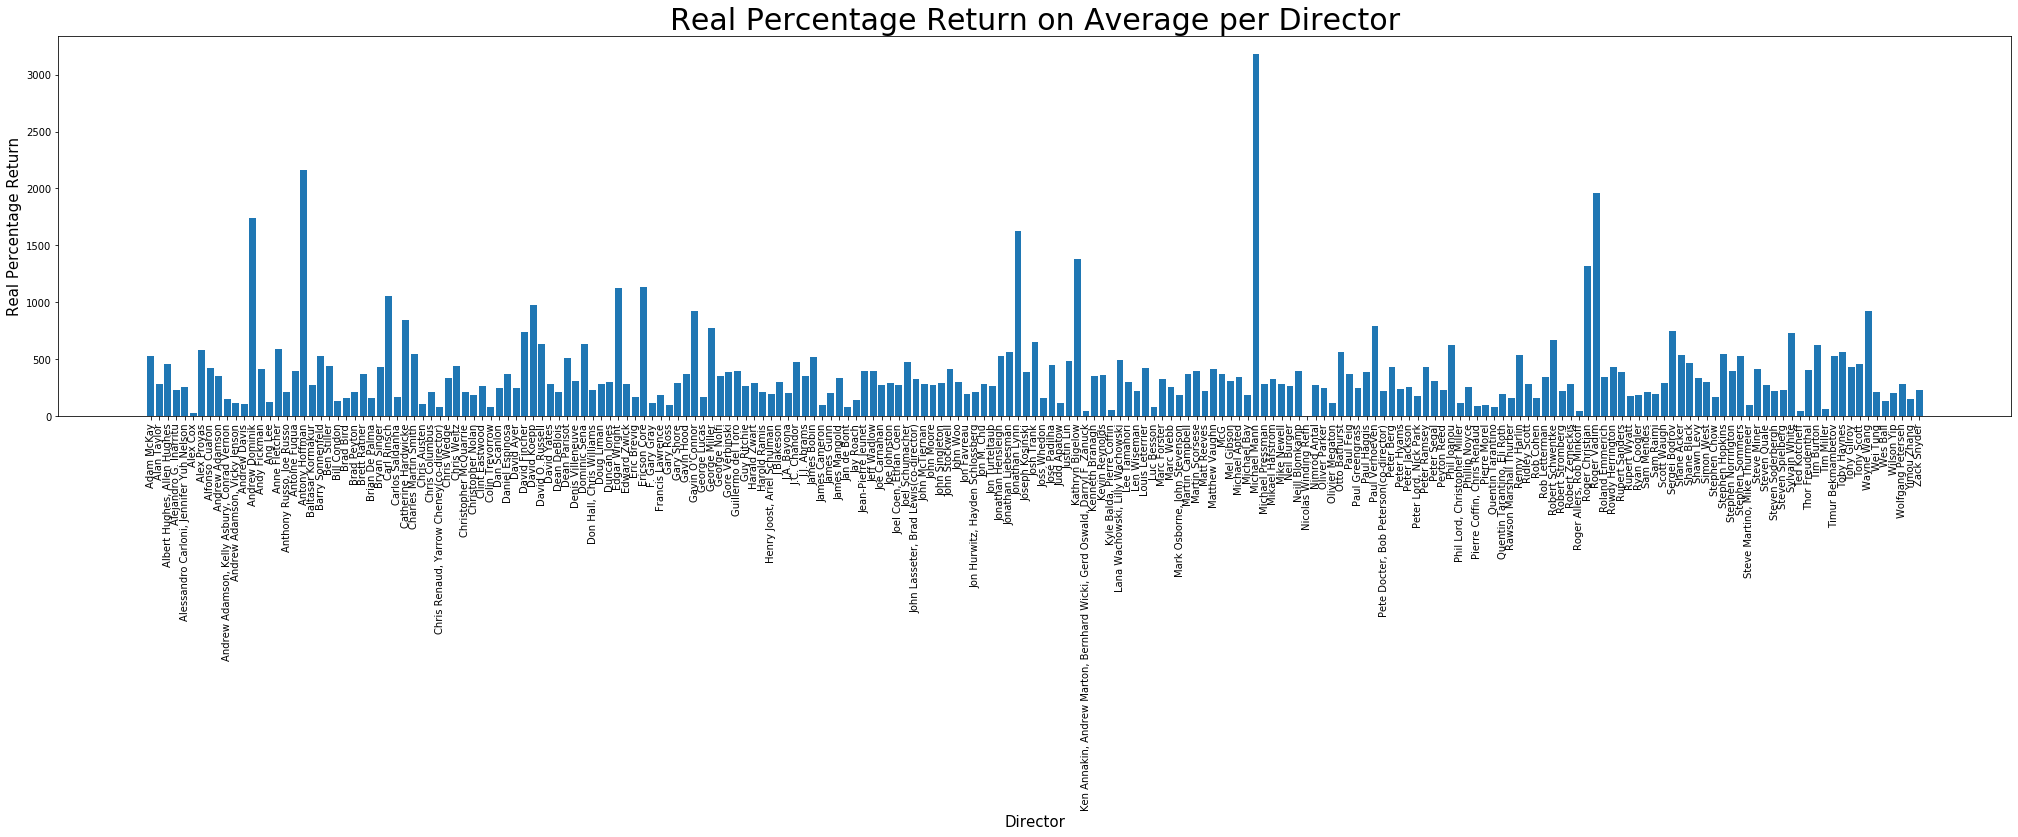

In [21]:
'''
3. For the data points that have budget, revenue (Worldwide-gross) and director (pick director_1) 
filled in the merged OMDb_mojo_clean.csv., can we calculate the percentage return on a movie? 
So it will be (budget/revenue) * 100% equals percentage return on a movie. 
I want to bin the movies by the director, so that we see which director has the highest percentage return on average. 
If you think a scatterplot would work better or some other chart, go ahead and do it.
'''
OMdb['pct_return'] = OMdb['real_budget']/OMdb['real_revenue']*100
revenue_director_df = pd.DataFrame(OMdb.groupby(by=['Director']).mean()['pct_return'])
plt.figure(figsize = (35,7))
plt.bar(revenue_director_df.index, revenue_director_df['pct_return'])
plt.title('Real Percentage Return on Average per Director', fontsize = 30)
plt.xlabel('Director', fontsize = 15)
plt.ylabel('Real Percentage Return', fontsize = 15)
plt.xticks(rotation = 90)
plt.savefig('images/real_percentage_return_per_director.png');

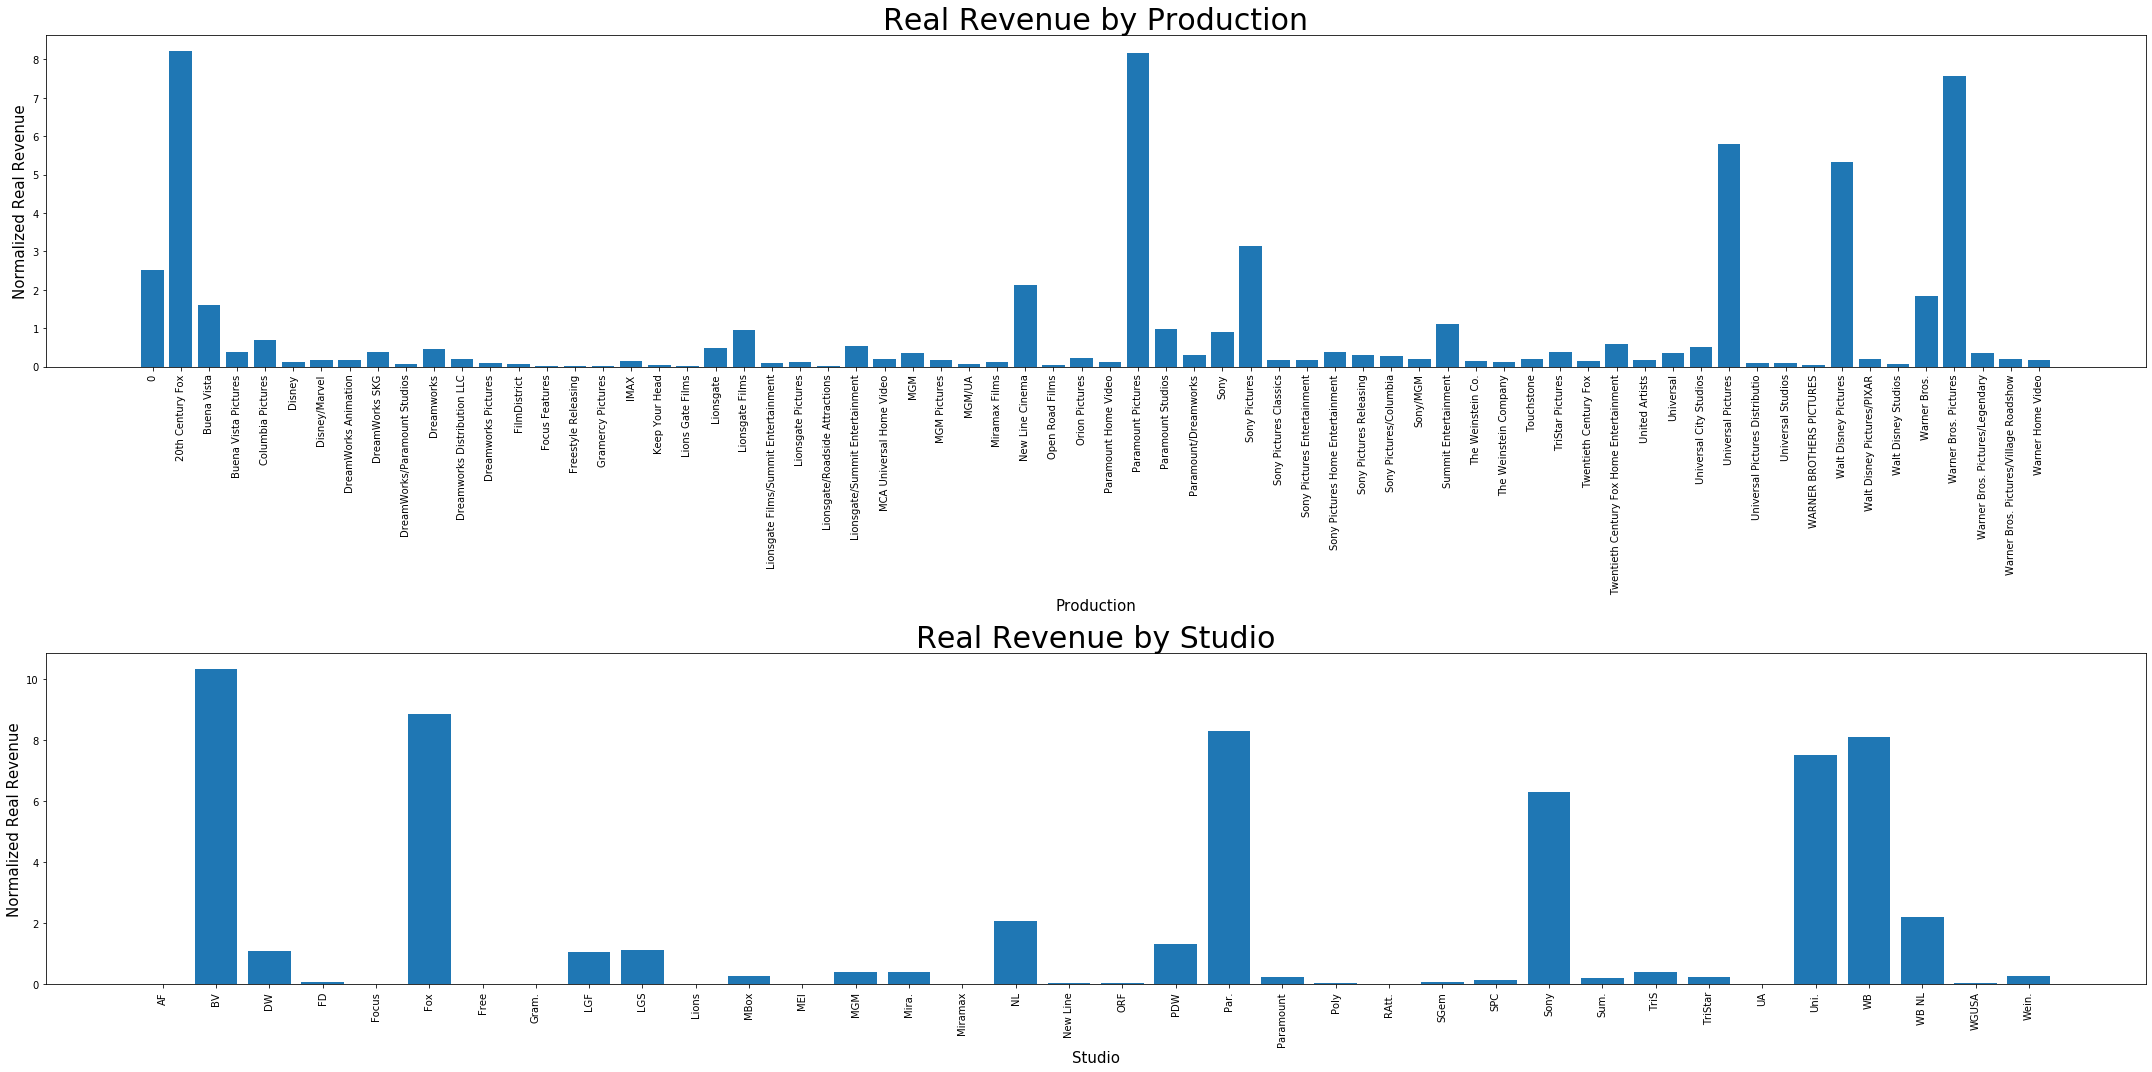

In [22]:
# a. Worldwide-gross to production studio
wwg_production_df = pd.DataFrame(OMdb.groupby(by=['Production']).sum()['real_revenue'])
wwg_studio_df = pd.DataFrame(OMdb.groupby(by=['studio']).sum()['real_revenue'])

plt.figure(figsize = (30,15))
ax1 = plt.subplot(2,1,1)
ax1.set_title('Real Revenue by Production', fontsize = 30)
ax1.bar(wwg_production_df.index, wwg_production_df['real_revenue'])
ax1.set_xlabel('Production', fontsize = 15)
ax1.set_xticklabels(wwg_production_df.index, rotation = 90)
ax1.set_ylabel('Normalized Real Revenue', fontsize = 15)

ax2 = plt.subplot(2,1,2)
ax2.set_title('Real Revenue by Studio', fontsize = 30)
ax2.bar(wwg_studio_df.index, wwg_studio_df['real_revenue'])
ax2.set_xlabel('Studio', fontsize = 15)
ax2.set_xticklabels(wwg_studio_df.index, rotation = 90)
ax2.set_ylabel('Normalized Real Revenue', fontsize = 15)

plt.tight_layout()
plt.savefig('images/real revenue to production vs. studio.png')

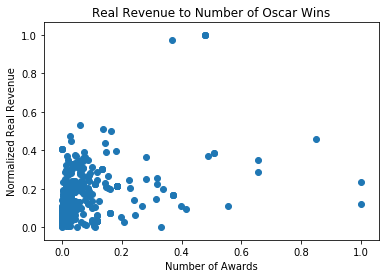

In [23]:
#d. Worldwide-gross to total # awards won
plt.scatter(OMdb['awards'], OMdb['real_revenue'])
plt.title('Real Revenue to Number of Oscar Wins')
plt.xlabel('Number of Awards')
plt.ylabel('Normalized Real Revenue')
plt.savefig('images/Real Revenue to Number of Oscar Wins.png');

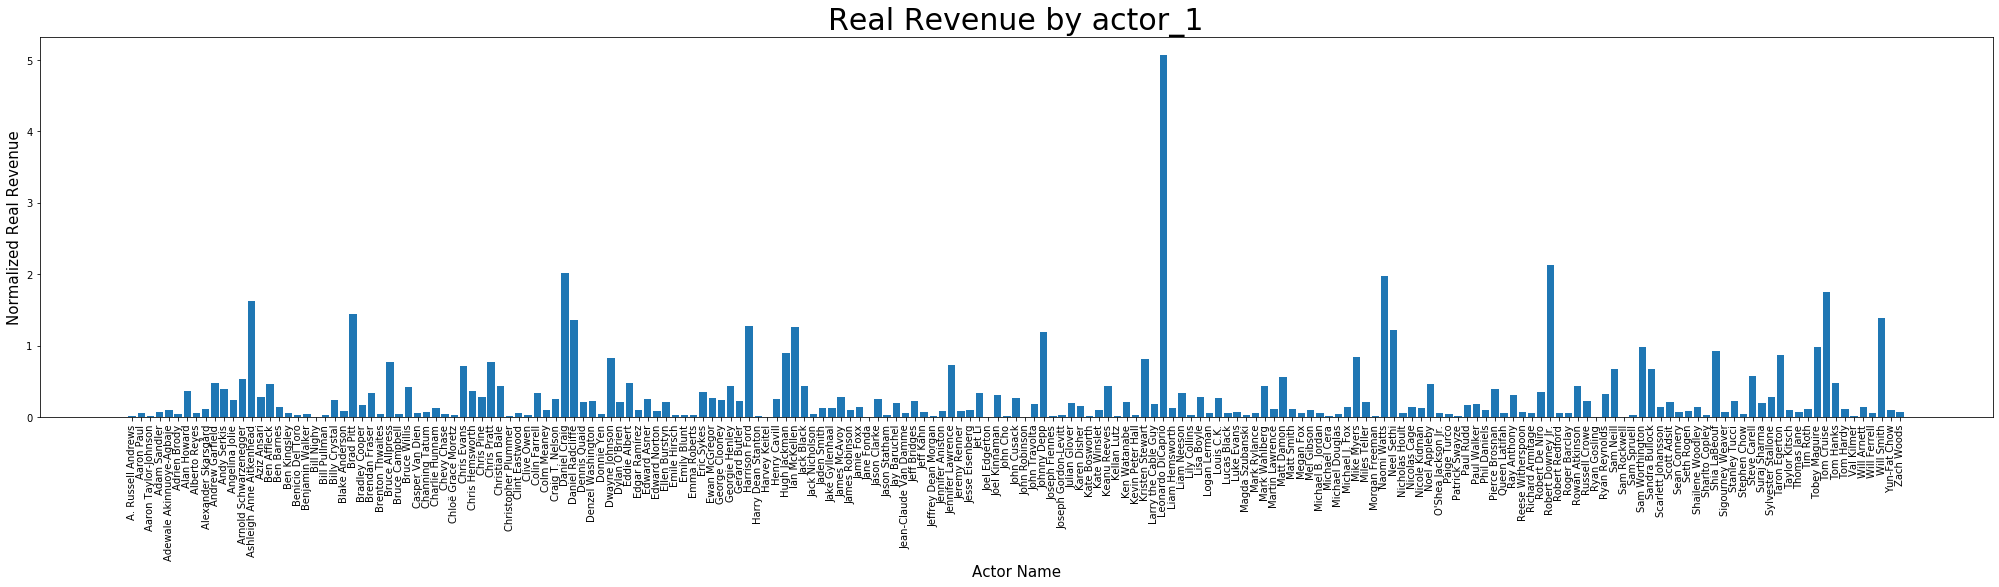

In [24]:
# Real Revenue to actor_1
wwg_actor1_df = pd.DataFrame(OMdb.groupby(by=['actor_1']).sum()['real_revenue'])
plt.figure(figsize = (35,7))
plt.bar(wwg_actor1_df.index, wwg_actor1_df['real_revenue'])
plt.title('Real Revenue by actor_1', fontsize = 30)
plt.xlabel('Actor Name', fontsize = 15)
plt.ylabel('Normalized Real Revenue', fontsize = 15)
plt.xticks(rotation = 90)
plt.savefig('images/Real Revenue to actor_1.png');

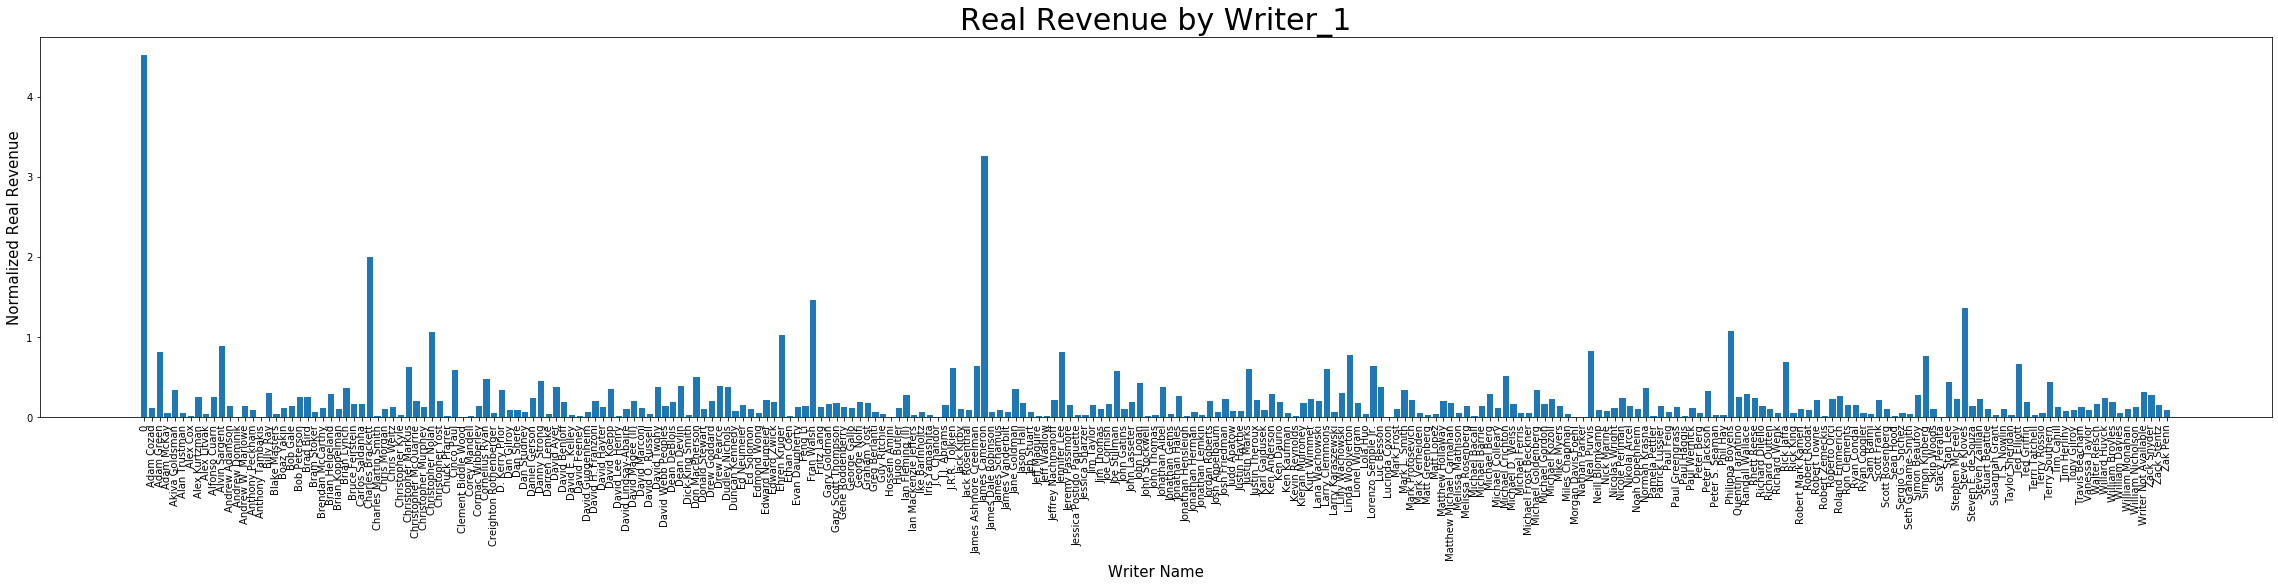

In [25]:
# Real Revenue to writer_1
wwg_writer_df = pd.DataFrame(OMdb.groupby(by=['Writer 1']).sum()['real_revenue'])
plt.figure(figsize = (40,7))
plt.bar(wwg_writer_df.index, wwg_writer_df['real_revenue'])
plt.title('Real Revenue by Writer_1', fontsize = 30)
plt.xlabel('Writer Name', fontsize = 15)
plt.ylabel('Normalized Real Revenue', fontsize = 15)
plt.xticks(rotation = 90)
plt.savefig('images/Real Revenue to writer_1.png');

### Modeling

B) Threshold/CriteriaforBinaryClassification:
Target/label = 1 if worldwide-gross >= median of the worldwide-gross column (adjusted for inflation)
0 if otherwise

In [26]:
revenue_median = OMdb_ohed['real_revenue'].median()
OMdb_ohed['target_revenue']= OMdb_ohed['real_revenue'].map(lambda x: 1 if x >= revenue_median else 0)

A) FeatureSelection/DimensionalityReduction:
We use SelectKBest to determine the highest impact features or combination of. 
>> Please provide output that indicates the impact on prediction accuracy of each
feature
>> Please provide output that indicates the subset of features that have highest impact
>> Output any other information this method can tell us in terms of which features matter
the most
Pick the subset determined with highest prediction accuracy to feed to the prediction
models listed in Part D


In [27]:
# For the feature columns I dropped worldwide-gross because real_revenue comes from worldwide-gross
# I also droped domestic-gross and overseas-gross because worldwide-gross = domestic-gross + overseas-gross
X = OMdb_ohed.drop(columns = ['worldwide-gross','target_revenue','domestic-gross','overseas-gross','real_revenue'])
y = OMdb_ohed['target_revenue']

In [28]:
# Select the top 20 features using SelectKbest
skb = SelectKBest(chi2, k = 20)
skb = skb.fit(X, y)
df_scores = pd.DataFrame(skb.scores_)
df_columns = pd.DataFrame(X.columns)
feature_df = pd.concat([df_columns, df_scores],axis=1)
feature_df.columns = ['features', 'score']

In [29]:
top20_df = feature_df.nlargest(20, 'score')
top20_df

,features,score
8,bo_year_rank,31.032644
0,BoxOffice,22.096014
1097,x4_Peter Jackson,17.000000
3986,x18_Peter Jackson,17.000000
2138,x10_R,16.000000
23,real_budget,15.318546
13,nominations,14.708069
4711,x22_BV,13.888889
10,imdbVotes,13.648388
22,budget,13.518549


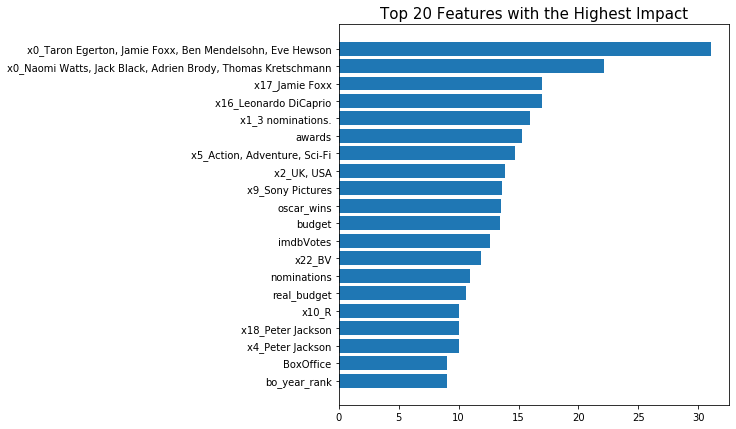

In [30]:
plt.figure(figsize=(7,7))
plt.barh(top20_df['features'], top20_df['score'].sort_values(ascending = True))
plt.title('Top 20 Features with the Highest Impact', fontsize = 15)
plt.savefig('images/selected features and impact socre.png');

C) Training Set Setup: Use 20%/80%

In [31]:
selected_cols = [feature for feature in top20_df['features']]
X = OMdb_ohed[selected_cols]
y = OMdb_ohed['target_revenue']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 2020, stratify = y)

D) Types of Prediction Models: Use the SelectKBest feature subset determined in Part A to make calls using the standard scikit library calls for:
>> Please output prediction accuracy metrics for each one of these prediction models ie prediction accuracy percentage, confusion matrix, confusion matrix with heatmap representation, accuracy metric, precision metric, recall metric, and anything else that might be useful

In [77]:
def metrics_output(ml, name):
    pred = ml.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    train_score = ml.score(X_train, y_train)
    test_score = ml.score(X_test, y_test)
    precision = tp/(tp+fp)
    recall = tp/(fn+tp)
    f = 2*precision * recall/(precision + recall)
    print(f'{name} training accuracy socre: {train_score}')
    print(f'{name} testing accuracy socre: {test_score}')
    print(f'{name}precision socre: {precision}')
    print(f'{name} recall socre: {recall}')
    print(f'{name} f-measure: {f}')
    

a) Logistic Regression

In [78]:
Logreg = LogisticRegression()
Logreg.fit(X_train, y_train)

LogisticRegression()

Text(0.5, 1.0, 'Logistic Regression Confusion Matrics')

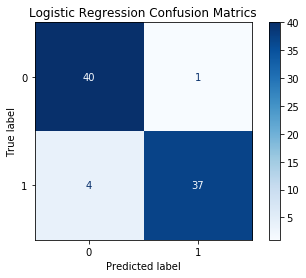

In [88]:
plot_confusion_matrix(Logreg, X_test, y_test, cmap = 'Blues')
plt.title('Logistic Regression Confusion Matrics')

In [80]:
metrics_output(Logreg, 'Logistic Regression')

Logistic Regression training accuracy socre: 0.8926380368098159
Logistic Regression testing accuracy socre: 0.9390243902439024
Logistic Regressionprecision socre: 0.9736842105263158
Logistic Regression recall socre: 0.9024390243902439
Logistic Regression f-measure: 0.9367088607594938


Text(0.5, 1.0, 'Logistic Regression ROC/AUC')

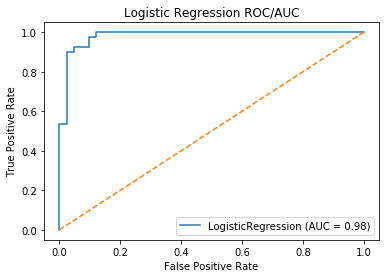

In [89]:
plot_roc_curve(Logreg, X_test, y_test)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         linestyle='--')
plt.title('Logistic Regression ROC/AUC')

b) SVM 

In [82]:
svm = SVC()

In [83]:
svm_params = {
    'C': np.linspace(0.0001, 1, 10),
    'kernel': ['rbf', 'linear']}

In [84]:
# use gridsearch to find out the best parameters
gs_svm = GridSearchCV(svm, svm_params, cv = 5)
gs_svm.fit(X_train, y_train)
gs_svm.best_params_

{'C': 1.0, 'kernel': 'rbf'}

Text(0.5, 1.0, 'SVM confusion matrix')

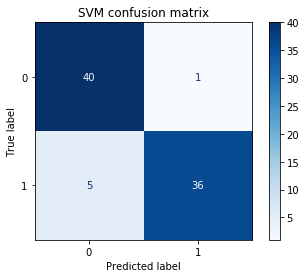

In [87]:
plot_confusion_matrix(gs_svm, X_test, y_test, cmap = 'Blues')
plt.title('SVM confusion matrix')

In [85]:
metrics_output(gs_svm, 'SVM with C = 1, kernel = rbf')

SVM with C = 1, kernel = rbf training accuracy socre: 0.9049079754601227
SVM with C = 1, kernel = rbf testing accuracy socre: 0.926829268292683
SVM with C = 1, kernel = rbfprecision socre: 0.972972972972973
SVM with C = 1, kernel = rbf recall socre: 0.8780487804878049
SVM with C = 1, kernel = rbf f-measure: 0.923076923076923


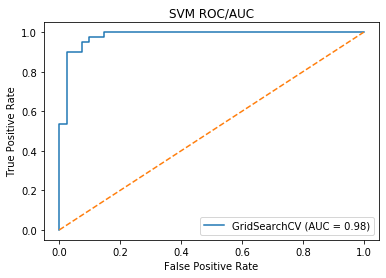

In [91]:
plot_roc_curve(gs_svm, X_test, y_test)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         linestyle='--')
plt.title('SVM ROC/AUC');

c) KNN

In [98]:
knn = KNeighborsClassifier()

In [99]:
knn_params = {
    'n_neighbors': [3, 5, 8],
    'metric': ['minkowski', 'manhattan']
}

In [100]:
gs_knn = GridSearchCV(knn, knn_params, cv =5)
gs_knn.fit(X_train, y_train)
gs_knn.best_params_

{'metric': 'minkowski', 'n_neighbors': 3}

Text(0.5, 1.0, 'KNN confusion matrix')

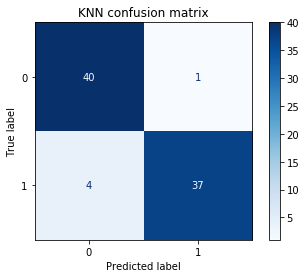

In [101]:
plot_confusion_matrix(gs_knn, X_test, y_test, cmap = 'Blues')
plt.title('KNN confusion matrix')

In [102]:
metrics_output(gs_knn, 'KNN with k = 3, distance metric = minkowski')

KNN with k = 3, distance metric = minkowski training accuracy socre: 0.9539877300613497
KNN with k = 3, distance metric = minkowski testing accuracy socre: 0.9390243902439024
KNN with k = 3, distance metric = minkowskiprecision socre: 0.9736842105263158
KNN with k = 3, distance metric = minkowski recall socre: 0.9024390243902439
KNN with k = 3, distance metric = minkowski f-measure: 0.9367088607594938


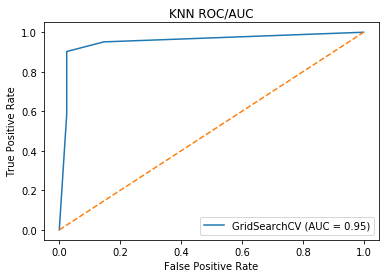

In [103]:
plot_roc_curve(gs_knn, X_test, y_test)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         linestyle='--')
plt.title('KNN ROC/AUC');

d) Naive Bayes

In [106]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

Text(0.5, 1.0, 'Naive Bayes confusion matrix')

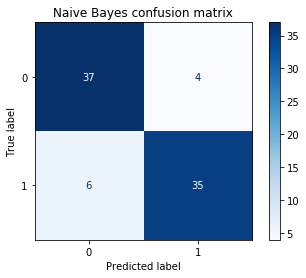

In [107]:
plot_confusion_matrix(nb, X_test, y_test, cmap = 'Blues')
plt.title('Naive Bayes confusion matrix')

In [108]:
metrics_output(nb, 'Naive Bayes')

Naive Bayes training accuracy socre: 0.8404907975460123
Naive Bayes testing accuracy socre: 0.8780487804878049
Naive Bayesprecision socre: 0.8974358974358975
Naive Bayes recall socre: 0.8536585365853658
Naive Bayes f-measure: 0.875


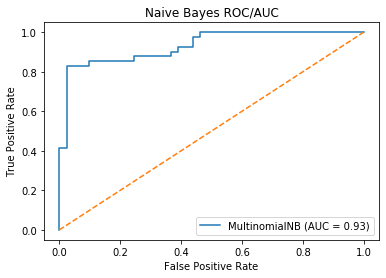

In [109]:
plot_roc_curve(nb, X_test, y_test)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         linestyle='--')
plt.title('Naive Bayes ROC/AUC');

E) Whichever model in Part D had the highest prediction accuracy (percentage wise), we do some k=5 cross validation. So test and train with first 20% of data, then 2nd 20% of data etc. And average out the prediction accuracy
>> Please output accuracy of each 20% block and show the average of all of them

In [110]:
# Since KNN and Logistic Regression have the exact same accuracy score, 
# I chose Logistic Regression to do the cross validation because Logreg has a higher AUC score.
cross_val_score(Logreg, X, y, cv =5)

array([0.85365854, 0.97560976, 0.91463415, 0.87654321, 0.82716049])